# Assignment 03

#### Task
<p style='text-align:justify;'>Prepare a proposal to foreign investors analyzing key difference and challenges faced in investment decisions. Integrating both economic and political analysis, forecast various market scenarios and identify the likely fiscal and monetary policy responses and their effects on investment environment.</p>



#### Assignment #2 revised:
<p>Since our assignment 2 submission was not upto mark, we decide to re-present our (revised) finding for the task #2. *This revision will be the basis of our analysis in assignment #3.<p>

In [1]:
'''importing requisite libraries'''
import wget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy

In [2]:
np.random.seed(0)

In [3]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 500)

In [4]:
# '''downloading data'''
# wget.download(url='https://raw.githubusercontent.com/NeelkanthMehta/MSFE_660/module_05/fredexport.csv', 
#               out='dataset.csv')

<font size=1.5> Note: We have formatted the data dump file offline, and have a clean working .csv file for the use.</font>
<br>**Explanation of variables...**
<p>We sourced the data from St. Louis FRED database. The dataset is far from ideal, however, its' monthly, as opposed to quaterly or annual. The following is a list of variables imported along with their chagacteristics (all data are seasonally unadjusted):

00. CPALTT01ZAM657N: CPI growth rate in percentage terms
01. EXSFUS: exchange rate based on ZA rand to 1 USD
02. INTGSBZAM193N: govt. securities yields in percentage
03. INTGSTZAM193N: Treasury rates
04. IRLTLT01ZAM156N: Long-Term govt. bond yields in percentage
05. MYAGM0ZAM189N: M0 in billion rands
06. MYAGM1ZAM189N: M1 in billion rands
07. MYAGM2ZAM189N: M2 in billion rands
08. MYAGM3ZAM189N: M3 in billion rands
09. TRESEGZAM052N: Total Reserves excluding gold (excluding drawing rights)
10. XTEITT01ZAM156N: Ratio of Exports to Imports in percentage

In [5]:
'''Loading and cleaning the dataset'''
location = 'C:/Users/neelkanth mehta/Documents/WQU/MScFE_660-Case_Studies_in_Risk_Management/module_05/group_assignment_02/fredexport.csv'
macro_features = pd.read_csv(filepath_or_buffer=location, index_col=0)
macro_features.index = pd.to_datetime(arg=macro_features.index, errors='coerce')

In [6]:
# We only require observations from 1980:2018-10
variables = macro_features['1980':'2018-10']

# converting to float
variables = variables.convert_objects(convert_numeric=True)

# filling missing values in non-linear manner
variables.interpolate(inplace=True, method='polynomial', order=3)

#variables.ffill(axis=1, inplace=True) # ffilling the NaN values
variables.info() # observing the dataset

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 466 entries, 1980-01-01 to 2018-10-01
Data columns (total 11 columns):
CPI               466 non-null float64
exchange_rate     466 non-null float64
gsec_int_rates    466 non-null float64
t_int_rates       466 non-null float64
LTg_yields        466 non-null float64
M0                449 non-null float64
M1                392 non-null float64
M2                313 non-null float64
M3                305 non-null float64
total_reserves    466 non-null float64
Ex_Im             466 non-null float64
dtypes: float64(11)
memory usage: 43.7 KB


C:\Users\neelkanth mehta\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """


In [7]:
'''formatting the dataset'''
variables['CPI'] = variables['CPI'].divide(100) # converted CPI to pct change
variables[['gsec_int_rates', 't_int_rates', 'LTg_yields']] = variables[['gsec_int_rates', 't_int_rates', 'LTg_yields']].pct_change()
variables[['M0', 'M1', 'M2', 'M3']] = variables[['M0', 'M1', 'M2', 'M3']].interpolate(method='linear').pct_change() # converting M0:M3 to delta values
variables['exchange_rate'] = variables['exchange_rate'].pct_change() # obtaining delta values of exchange rate
variables[['total_reserves', 'Ex_Im']] = variables[['total_reserves', 'Ex_Im']].pct_change() # all the variables changed to their delta values
variables = variables[1:]

In [8]:
from sklearn.preprocessing import Normalizer

normalize = Normalizer()
variables_norm = pd.DataFrame(data=normalize.fit_transform(variables), 
                            index=variables.index, 
                            columns=variables.columns.tolist())

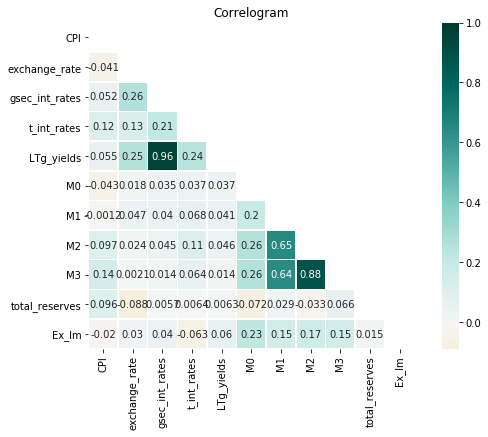

In [9]:
'''Visualizing the correlation matrix'''
correlogram = variables.corr()
mask = np.zeros_like(a=correlogram, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.rcParams['figure.figsize'] = [10,6]
sns.heatmap(data=correlogram, annot=True, center=0, square=True, linewidths=0.5, cmap='BrBG', mask=mask)
plt.title('Correlogram')
plt.show()

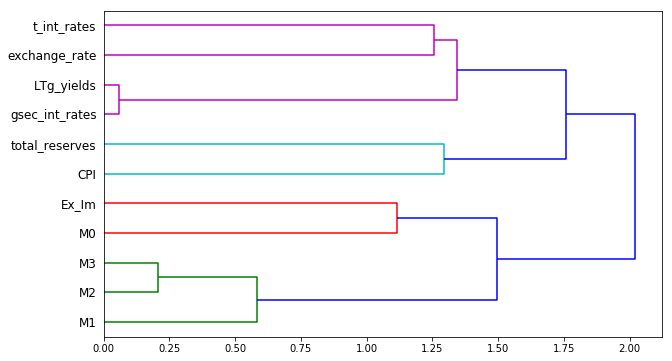

In [10]:
# final dendrogram
Z = hierarchy.linkage(correlogram, method='complete')
dendro = hierarchy.dendrogram(Z, labels=correlogram.columns.tolist(), orientation='right')

<p style='text-align:justify;'>From the above heatmap of correlogram, we can see high level of correlation present amongst the variables. The result of any model fitted on a such highly correlated data will be biased.
We therefore need to filter out redundant variables.
By heuristic approach, i.e., close observation of the above graph, one could safely conclude the variable of choice must be one from each category, *viz*., one of the interest rates, one of the money supply, exchange rate, inflation rate and trade balance.
The set of variables, with least overall correlation, to be used are:</p>

00. LT govt. yields.
01. M2 money supply.
02. CPI
03. Export-to-Import ratio.

In [29]:
factors = variables_norm[['LTg_yields', 'CPI', 'M2', 'Ex_Im']]

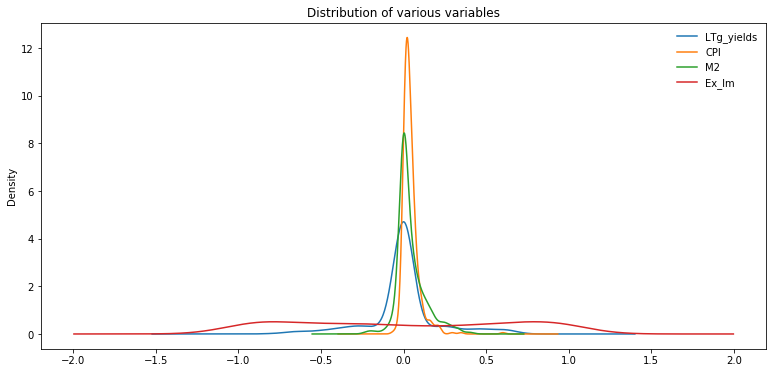

In [30]:
for i in factors.columns:
    factors[i].plot.kde(alpha=1);
plt.legend(labels=factors.columns, frameon=False, loc='best')
plt.title('Distribution of various variables')
plt.show()

#### Dimensionality reduction through PCA

In [31]:
'''Performing PCA on standardized data'''
from sklearn.decomposition import PCA
components = PCA()
scaled_variables = components.fit_transform(factors)

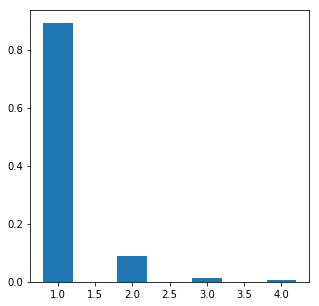

In [32]:
plt.figure(figsize=(5,5))
plt.bar(x=[1,2,3,4], height=components.explained_variance_ratio_, width=0.4);

In [33]:
'''Performing PCA on standardized data to come up with two components'''
components_2 = PCA(n_components=2)
scaled_variables_2 = components_2.fit_transform(factors.T)
p_components = pd.DataFrame(data=scaled_variables_2, columns=['comp_1', 'comp_2'], index=factors.columns.tolist())

print(f"{components_2.explained_variance_ratio_}")
print('='*80)
p_components.head()

[0.90255698 0.08425261]


,comp_1,comp_2
LTg_yields,-3.836413,3.106288
CPI,-3.584225,-1.474806
M2,-3.452787,-1.701131
Ex_Im,10.873425,0.069649


No handles with labels found to put in legend.


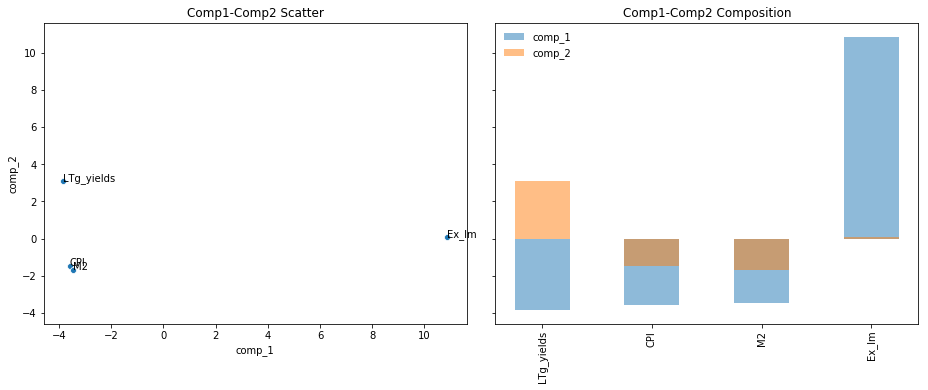

In [34]:
plt.rcParams['figure.figsize'] = (13,6)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True);
sns.scatterplot(x=p_components.comp_1, y=p_components.comp_2, ax=ax1);
ax1.set_title('Comp1-Comp2 Scatter')
ax1.legend(title=None, frameon=False, loc='best')
for sample in p_components.index:
    ax1.annotate(sample, (p_components.comp_1.loc[sample], p_components.comp_2.loc[sample]))
ax2.bar(x=p_components.index, height=p_components.comp_1, width=0.5, alpha=0.5);
ax2.bar(x=p_components.index, height=p_components.comp_2, width=0.5, alpha=0.5);
ax2.legend(labels=p_components.columns, loc='best', frameon=False, title=None)
ax2.set_title('Comp1-Comp2 Composition')
plt.xticks(rotation=90)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Comments on the graph:
In machine learning parlance; the above analysis suggests

1. Exchange rate could be most sensitive variable to consider while pricing an asset. The fact that South African Rand has been declining in value compared USD over twenty-three year period supports the results.
2. These 2 highest features is next followed by Net-exports, explaining significant bit in variability. The thrust of RDP and GEAR programs were to move the base of the local economy from mining based to manufacturing base. Until period 2008-09, this strategy did bear fruits, until the global recession hit its shores.

Nonetheless...the above drawn conclusions should be taken with 'grain of salt':

1. Note 01: the quality of this analysis is directly dependent to the quality of the data. Good, unadjusted and granular dataset is difficult to come by. We found one on St. Louis FRED database.
2. Note 02: this is a 'quick-n-dirty' analysis. The variables in the data do not depict gaussian distribution; neither is the time-series stationary.

### Model fitting 

In [39]:
# from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [46]:
def tsaplot(y, title, lags=None, figsize=(12,8)):
    '''
    Examine he patterns of ACF and PACF along with the time series plot and histogram
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(shape=layout, loc=(0,0))
    kde_ax = plt.subplot2grid(shape=layout, loc=(0,1))
    acf_ax = plt.subplot2grid(shape=layout, loc=(1,0))
    pacf_ax = plt.subplot2grid(shape=layout, loc=(1,1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=14, fontweight='bold')
    y.plot.kde(ax=kde_ax)
    kde_ax.set_title('Distribution')
    plot_acf(x=y, lags=lags, ax=acf_ax)
    plot_pacf(x=y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

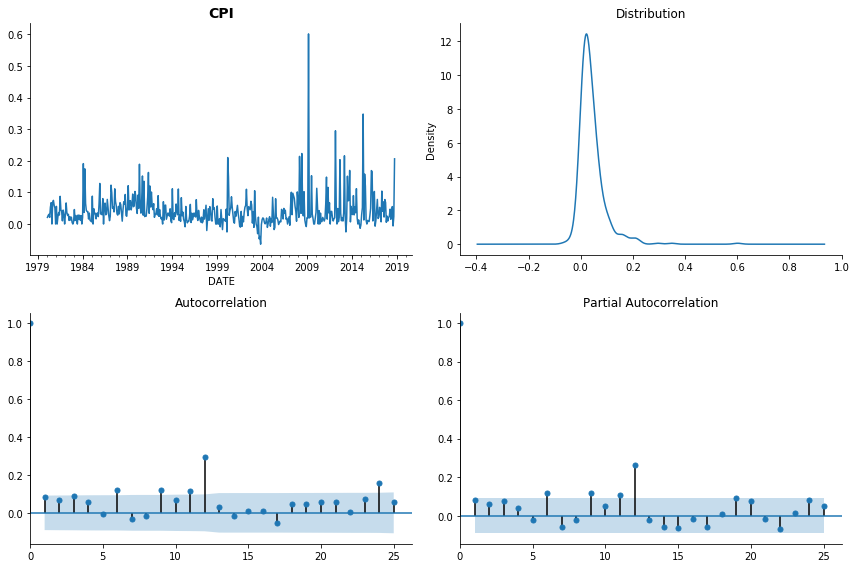

In [48]:
tsaplot(y=factors['CPI'], title='CPI', lags=25);